# 02 - Evaluating the Xception Model

Due to its ***Xceptional*** (*pun intended*) performance, I want to further break down the performance of the Xception model. I will also use this one to generate predictions and link it to the Streamlit app in the following notebooks. <br>

In the medical field, accuracy alone is not enough to claim success of a model. This is especially true when we have multiple classes present. For example, maybe we're 100% correct in predicting one class, but the remaining misclassified predictions are affecting our ability to predict another class. This is why we need to assess model's performance further on precision and recall. <br> 

**Precision** can be thought of as the accuracy of our accurate predictions. In other words, of all the predictions we claimed belong to a certain class, how many of them are actually accurate?

**Recall**, on the other hand, is a measure of how many instances of a class we correctly identified as belonging to that class. 

---
## 1. Recreating `test_data_gen` Dataset

The Xception model was saved, so I can import that here. However, I need to recreate the `test_data_gen` dataset using `ImageDataGenerator()` again since I'm working in a new environment. The remainder of the work will be done in Jupyter Lab, ***not Google Colab***.

In [4]:
# to start, I just need to recreate the test_data_gen since new notebook, new environment

# imports!
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# os & image imports
import os
from PIL import Image

# tensorflow
import tensorflow as tf

# keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision, Recall, SpecificityAtSensitivity, SensitivityAtSpecificity

# sklearn
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split # need this to split the train set into train/test for model training
from sklearn.metrics import precision_score, recall_score, classification_report

In [5]:
# test directory
test_directory = './data/archive/Testing'

In [6]:
# same function as before
def image_to_df(filepath):

    base = os.listdir(filepath)
    base.remove('.DS_Store') # removes this element from the list, remaining should be the actual folders

    label = []
    img_path = []
    folder_path = []

    for folder_name in base:
        images = os.listdir(filepath + f'/{folder_name}')
        for i in images:
            if i.endswith(".jpg"):
                label.append(folder_name)
                img_path.append(f'{filepath}/{folder_name}/{i}')
                folder_path.append(f'{filepath}/{folder_name}')

    return pd.DataFrame(data={'folder_path': folder_path,'img_path': img_path, 'label': label})

In [36]:
# storing the output of the function for test data
test_df = image_to_df(test_directory)

test_df.head()

,folder_path,img_path,label
0,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0233.jpg,pituitary
1,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0227.jpg,pituitary
2,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0019.jpg,pituitary
3,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0031.jpg,pituitary
4,./data/archive/Testing/pituitary,./data/archive/Testing/pituitary/Te-pi_0025.jpg,pituitary


In [37]:
test_df['img_path']

0         ./data/archive/Testing/pituitary/Te-pi_0233.jpg
1         ./data/archive/Testing/pituitary/Te-pi_0227.jpg
2         ./data/archive/Testing/pituitary/Te-pi_0019.jpg
3         ./data/archive/Testing/pituitary/Te-pi_0031.jpg
4         ./data/archive/Testing/pituitary/Te-pi_0025.jpg
                              ...                        
1306     ./data/archive/Testing/meningioma/Te-me_0080.jpg
1307     ./data/archive/Testing/meningioma/Te-me_0094.jpg
1308     ./data/archive/Testing/meningioma/Te-me_0137.jpg
1309     ./data/archive/Testing/meningioma/Te-me_0123.jpg
1310    ./data/archive/Testing/meningioma/Te-meTr_0009...
Name: img_path, Length: 1311, dtype: object

In [8]:
# instantiate generator for test 
idg_test = ImageDataGenerator(rescale = 1./255,) #only the rescaling is needed

test_data_gen = idg_test.flow_from_dataframe(test_df,
                             x_col = 'img_path',
                             y_col = 'label',
                             class_mode = 'categorical',
                             target_size = (256,256),
                             batch_size = 32,
                             color_mode = 'rgb',
                             shuffle = False,
                             classes = {'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}) # setting the default class indices

Found 1311 validated image filenames belonging to 4 classes.


---
## 2. Evaluating Performance

In [9]:
# load Xception model
xception = tf.keras.models.load_model('./assets/cnn_models/model2.h5')

### 2a. Regenerate the predictions

In [10]:
pred_probs = xception.predict(test_data_gen)

41/41 [==============================] - 99s 2s/step


In [12]:
# convert probabilities into single list of predictions
preds = np.argmax(pred_probs, axis = 1)
preds

array([3, 3, 1, ..., 2, 2, 2])

In [13]:
y_test = test_data_gen.classes

In [14]:
# overall roughly 95% accuracy
(preds == y_test).mean()

0.9511823035850496

In [15]:
precision_score(y_test, preds, average=None, )

array([0.99012346, 0.86127168, 0.96283784, 0.99621212])

In [16]:
recall_score(y_test, preds, average = None, )

array([0.99012346, 0.99333333, 0.93137255, 0.87666667])

In [17]:
summary = pd.DataFrame(classification_report(y_test, preds, output_dict = True))
summary.rename({'0': 'notumor', '1': 'glioma', '2': 'meningioma', '3': 'pituitary'}, axis = 1, inplace = True)

In [18]:
summary

,notumor,glioma,meningioma,pituitary,accuracy,macro avg,weighted avg
precision,0.990123,0.861272,0.962838,0.996212,0.951182,0.952611,0.955662
recall,0.990123,0.993333,0.931373,0.876667,0.951182,0.947874,0.951182
f1-score,0.990123,0.922601,0.946844,0.932624,0.951182,0.948048,0.951412
support,405.000000,300.000000,306.000000,300.000000,0.951182,1311.000000,1311.000000


Overall, the model's precision and recall scores are promising. Again, despite the model being simple in architecture, we were able to get some strong predictions. <br>

Precision and Recall are extremely important to look at aside from just accuracy, especially when it comes to the medical field. For example, if a majority of people did not have tumors in our dataset, accuracy would be meaningless since the baseline for predicting with a totally random classifier would be high enough. In that case, what becomes important i **accurately** predicting which cases are positive. <br> 

Similarly, in this multiclass classification problem, we don't want to just focus on overall accuracy. We want to see if we can accurately predict the occurrence of each class of tumor. <br>

#### **Precision**
Precision is essentially the ratio between true positives and **all** positives (for a class) in our dataset. The model achieved relatively high precision scores for "notumor", "pituitary", and "meningioma". Meaning that, for example, of the 405 cases that were predicted as "notumor" (referring to graph "cm_model2.jpeg"), we inaccurately labeled just 4 of them - achieving a precision of 99.01%. This metric can be interpreted similarly for the other classes. <br> Glioma was the most difficult class to accurately predict. Of the 346 predictions for 'glioma", only 298 actually were "glioma". In hindsight, it may make sense as to why "notumor" and "pituitary" had the sharpest precision scores. Images pertaining to those classes are likely easier to distinguish than the other 2 types of tumors. Pituitary tumors, very specifically, are found in a particular region of the brain, the Pituitary gland. 

#### **Recall**
Recall explains our model's ability to **accurately** identify the true positives in the dataset. For example, notice how the "notumor" class' precision and recall are the same. This is because, like the precision score, there were a total of 405 "notumor" actual cases, of which, we correctly identified 401. This metric can be interpreted similarly for the other classes. Our recall was the worst for "pituitary". <br>

#### **Other Notes**
Another thing we can consider is, in the context of this particular scenario, what is more important? I would argue it is definitely worse to predict a false negative - that is to say that we predicted someone to have "notumor" and our prediction was incorrect. In the real world, this can have life threatening consequences for a number of reasons associated directly to the tumor going unnoticed. <br> Our model's overall false negative ratio (across the 3 actual tumor classes), is relatively low. For example, referring back again to graph "cm_model2.jpeg", of all the **actual** tumor cases (either pituitary, glioma, or meningioma), we incorreclty predicted and misclassified 4 cases. The remaining were either correctly identified, or identified as some other type of tumor. In the real world, this would of course be a problem if the model's prediction alone were to determine a treatment plan (which would be incorrect for the type of tumor the patient actually has). However, in the real world, ideally the model's predictions would serve as a complementary opinion to that of one, or several, medical professionals. 

#### **Conclusion**
To conclude, the presence of A.I. image classification models can certainly be of use in the medical field. As we saw in this exercise, despite being a relatively shallow model with no additional architecture beyond its base, the Xception CNN model achieved an accuracy of 95%, while maintaing precision and recall scores as high as 99% across 3 of 4 classes. Ideally, these models could be even more powerful at achieving near human intelligence level predictions if they are trained more on parameters that are specific to MRI images of brains, or if they are potentially fed additional non-image based data on respective patients.

**Confusion Matrix - Model 2, Xception** (*printed below for reference*)

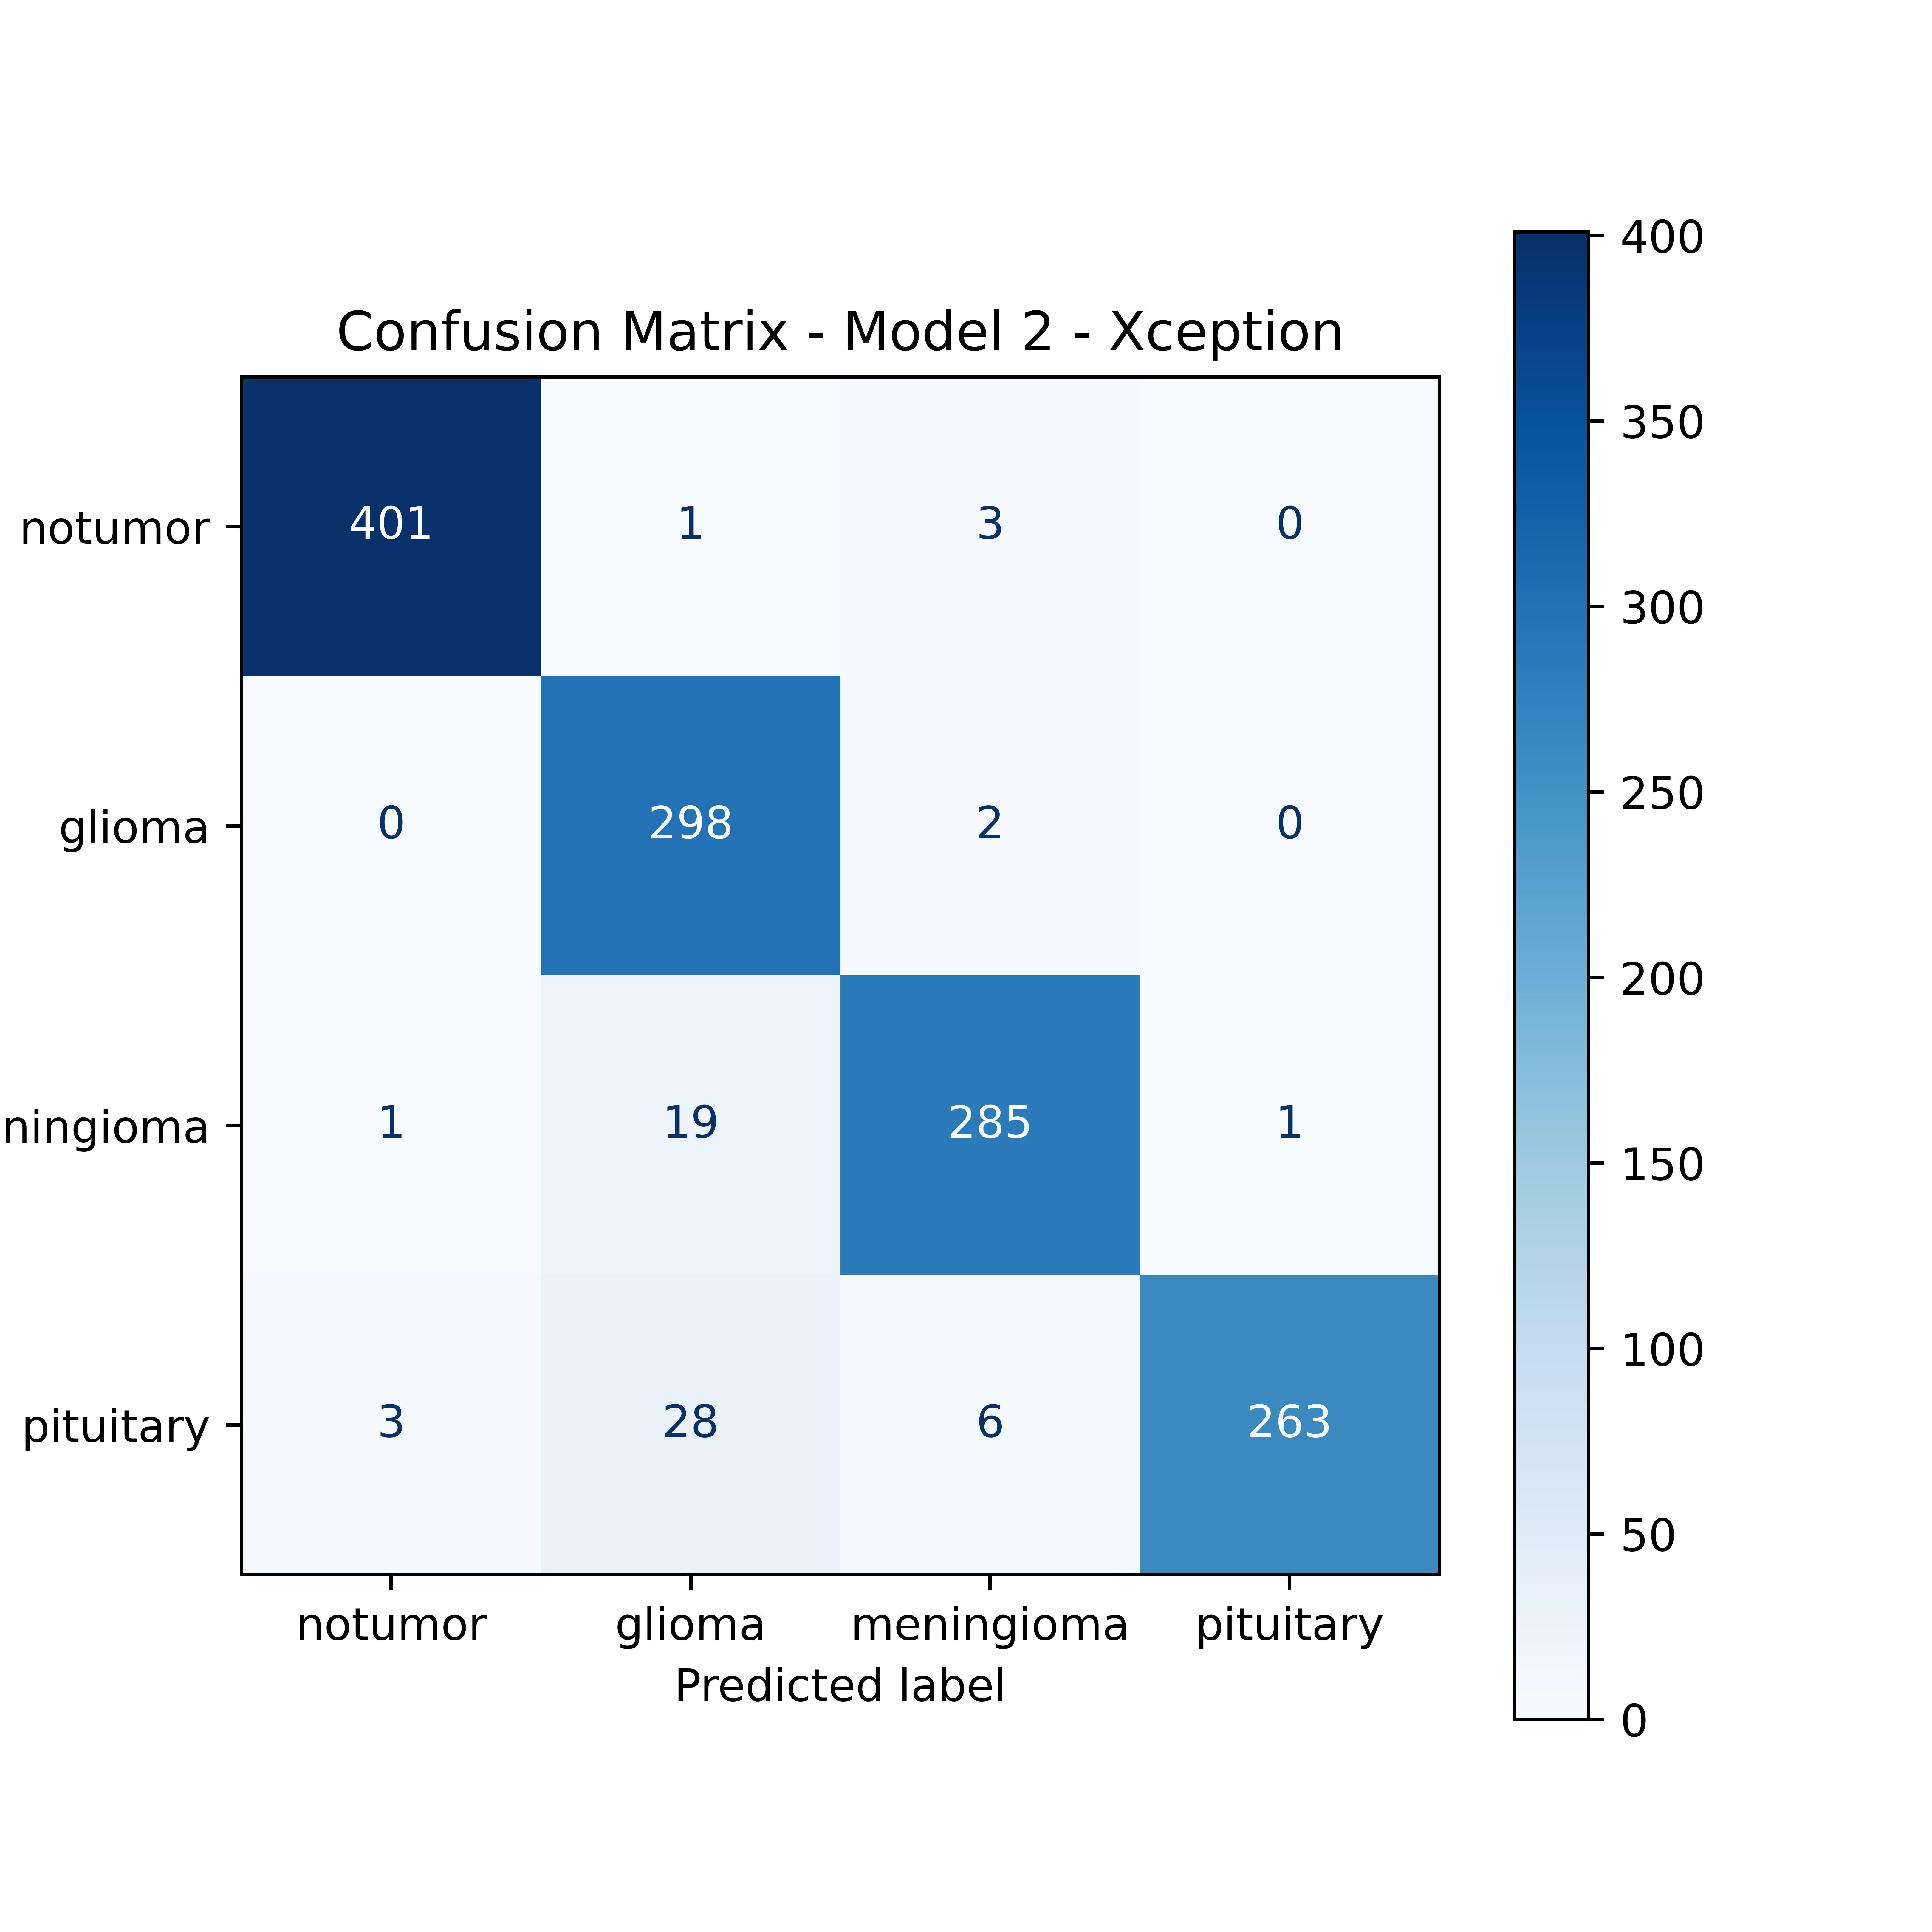

In [5]:
Image.open('./graphs/cm_model2.jpeg',)